In [2]:
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import uniform, randint
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)


In [31]:
# Load four data files
order_items = pd.read_csv(r"D:\New_Desktop\project-main\clean_data\order_items.csv")
reviews = pd.read_csv(r"D:\New_Desktop\project-main\clean_data\olist_order_reviews_dataset.csv")
orders = pd.read_csv(r"D:\New_Desktop\project-main\clean_data\orders_dataset.csv", parse_dates=["order_purchase_timestamp"])
products = pd.read_csv(r"D:\New_Desktop\project-main\clean_data\products.csv")

# Sort order data by purchase timestamp
orders_sorted = orders.sort_values(by="order_purchase_timestamp", ascending=True)

合并表格

In [32]:
# Merge order_items → orders → products → reviews in sequence
merged_df = pd.merge(order_items, orders, on="order_id", how="inner")
merged_df = pd.merge(merged_df, products, on="product_id", how="left")
merged_df = pd.merge(merged_df, reviews[['order_id', 'review_score']], on="order_id", how="inner")

# Inspect the structure of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108403 entries, 0 to 108402
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       108403 non-null  object        
 1   order_item_id                  108403 non-null  int64         
 2   product_id                     108403 non-null  object        
 3   seller_id                      108403 non-null  object        
 4   shipping_limit_date            108403 non-null  object        
 5   price                          108403 non-null  float64       
 6   freight_value                  108403 non-null  float64       
 7   year_month                     108403 non-null  object        
 8   month                          108403 non-null  int64         
 9   weekday                        108403 non-null  int64         
 10  customer_id                    108403 non-null  object        
 11  

## 特征工程

In [21]:
# Aggregate by order_id to compute total order value and the number of items per order
order_agg = merged_df.groupby('order_id').agg(
    total_order_value=('price', 'sum'),
    total_order_count=('order_item_id', 'count')
).reset_index()

# Merge the aggregated results back into the original dataset
merged_df = pd.merge(merged_df, order_agg, on='order_id', how='left')


In [26]:
# Construct new features
merged_df['price_per_weight'] = merged_df['price'] / merged_df['product_weight_g'].replace(0, np.nan)
merged_df['description_density'] = merged_df['product_description_lenght'] / merged_df['product_name_lenght'].replace(0, np.nan)
merged_df['freight_ratio'] = merged_df['freight_value'] / merged_df['price'].replace(0, np.nan)
merged_df['delivery_ratio'] = merged_df['delivery_time'] / merged_df['shipping_time'].replace(0, np.nan)

# Construct time-related features
merged_df['month'] = merged_df['order_purchase_timestamp'].dt.month
merged_df['weekday'] = merged_df['order_purchase_timestamp'].dt.weekday
merged_df['price_freight_ratio'] = merged_df['price'] / merged_df['freight_value'].replace(0, np.nan)

# List of all features
engineered_features = [
    'price', 'freight_value', 'price_freight_ratio', 'product_photos_qty',
    'product_name_lenght', 'product_description_lenght', 'product_weight_g',
    'product_length_cm', 'product_height_cm', 'product_width_cm',
    'processing_time_approved', 'shipping_time', 'delivery_time',
    'total_order_value', 'total_order_count', 'month', 'weekday',
    'price_per_weight', 'description_density', 'freight_ratio', 'delivery_ratio'
]


# 使用互信息方法评估特征重要性

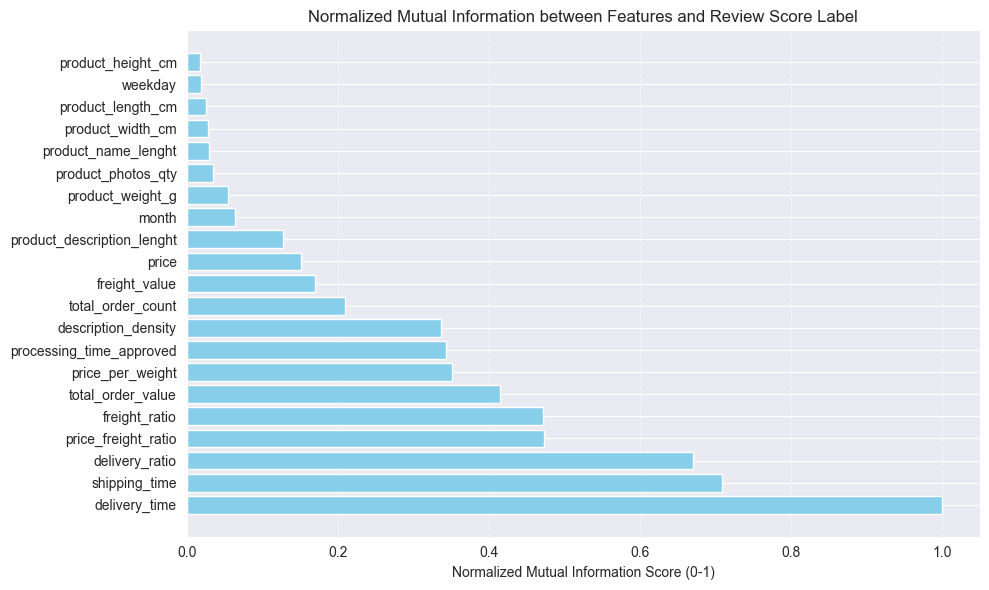

                       feature  mutual_information  normalized_mi
12               delivery_time            0.096761       1.000000
11               shipping_time            0.068567       0.708619
20              delivery_ratio            0.064859       0.670304
2          price_freight_ratio            0.045743       0.472740
19               freight_ratio            0.045612       0.471391
13           total_order_value            0.040143       0.414871
17            price_per_weight            0.033961       0.350973
10    processing_time_approved            0.033166       0.342762
18         description_density            0.032595       0.336863
14           total_order_count            0.020334       0.210142
1                freight_value            0.016402       0.169506
0                        price            0.014654       0.151449
5   product_description_lenght            0.012340       0.127535
15                       month            0.006160       0.063658
6         

In [29]:
# Prepare data by removing missing values
mi_df = merged_df[engineered_features + ['review_score']].dropna()
mi_df['review_label'] = mi_df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Features and labels
X = mi_df[engineered_features]
y = mi_df['review_label']

# Compute mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=False, random_state=42)

# Normalize mutual information to the [0, 1] range
max_mi = mi_scores.max()
normalized_mi = mi_scores / max_mi if max_mi > 0 else mi_scores

# Organize results into a DataFrame
mi_result = pd.DataFrame({
    'feature': engineered_features,
    'mutual_information': mi_scores,
    'normalized_mi': normalized_mi  # Add normalized mutual information column
}).sort_values(by='mutual_information', ascending=False)

# Visualize normalized mutual information
plt.figure(figsize=(10, 6))
plt.barh(mi_result['feature'], mi_result['normalized_mi'], color='skyblue')
plt.title('Normalized Mutual Information between Features and Review Score Label')
plt.xlabel('Normalized Mutual Information Score (0-1)')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()

# Display the normalized result
print(mi_result.sort_values(by='normalized_mi', ascending=False))

### 将数据集划分为训练集和测试集

In [11]:
# Use the features recommended in the previous step
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]

# Data preprocessing
model_df = merged_df[final_features + ['review_score']].dropna()
model_df['review_label'] = model_df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

# Raw data preparation (including features and review_label)
data = model_df[final_features + ['review_label']].dropna()

# First, split the raw data into a training set and a validation set
train_df, valid_df = train_test_split(
    data, test_size=0.2, random_state=42, stratify=data['review_label']
)
# Save as a CSV file
train_df.to_csv(r"D:\桌面\project\data\clean\train.csv", index=False)
valid_df.to_csv(r"D:\桌面\project\data\clean\valid.csv", index=False)


# 模型训练

## XGboost

In [3]:
# Read CSV data
train_df = pd.read_csv(r"D:\New_Desktop\project-main\Final data\train.csv")
valid_df = pd.read_csv(r"D:\New_Desktop\project-main\Final data\valid.csv")

Fitting 3 folds for each of 200 candidates, totalling 600 fits


D:\Python3.11.5\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:45:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python3.11.5\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:45:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python3.11.5\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:45:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Python3.11.5\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:45:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
D:\Pytho

=== Best Parameters (XGBoost) ===
{'colsample_bytree': 0.7118280434105517, 'gamma': 0.2822300690062754, 'learning_rate': 0.19504966348313318, 'max_depth': 9, 'min_child_weight': 2, 'n_estimators': 164, 'scale_pos_weight': 2, 'subsample': 0.9746464892764125}

=== Classification Report (XGBoost) ===
Class 0:
  Precision: 0.6583
  Recall:    0.4349
  F1-score:  0.5238
  Support:   5698.0

Class 1:
  Precision: 0.8266
  Recall:    0.9227
  F1-score:  0.8720
  Support:   16639.0

Overall Accuracy: 0.7982719255047679
Macro Avg F1-score: 0.6979057947833113
Weighted Avg F1-score: 0.78319556847057


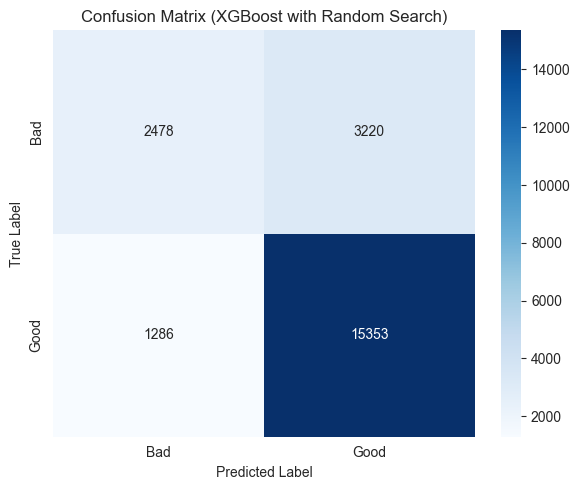

In [4]:

# Use the features recommended in the previous step
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]
# Separate features and labels
X_train = train_df[final_features]
y_train = train_df['review_label']

X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Construct an XGBoost model
xgb = XGBClassifier(
    scale_pos_weight=5,  # Apply stronger penalties to the minority class
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Define the parameter search space (wider range)
param_dist = {
    'n_estimators': randint(80, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'gamma': uniform(0, 0.4),
    'min_child_weight': randint(1, 6),
    'scale_pos_weight': [1, 2, 3]  # Address class imbalance
}

# Perform hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=200,  # Number of iterations
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1
)

# Apply SMOTE oversampling to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train and tune the model
random_search.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate using the best model
xgb_model = random_search.best_estimator_
# Predictions
y_pred = xgb_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("=== Best Parameters (XGBoost) ===")
print(random_search.best_params_)

print("\n=== Classification Report (XGBoost) ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (XGBoost with Random Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Random Forest

Fitting 3 folds for each of 1 candidates, totalling 3 fits
=== Best Parameters ===
{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}

=== Classification Report ===
Class 0:
  Precision: 0.6709
  Recall:    0.5895
  F1-score:  0.6276
  Support:   5698.0

Class 1:
  Precision: 0.8650
  Recall:    0.9010
  F1-score:  0.8826
  Support:   16639.0

Overall Accuracy: 0.8215069167748579
Macro Avg F1-score: 0.7550927474894032
Weighted Avg F1-score: 0.8175615771104623


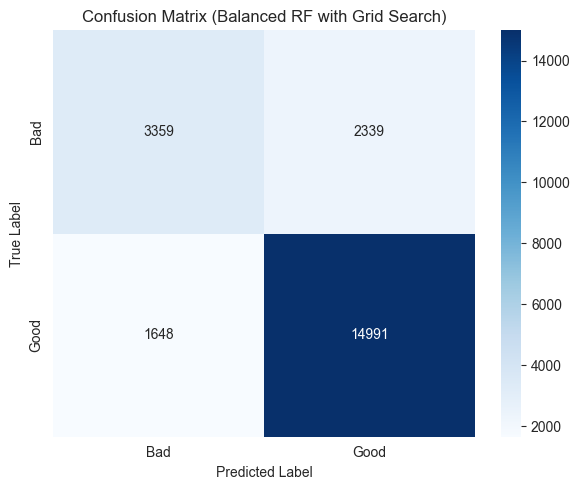

In [5]:
# Feature Selection
final_features = [
    'delivery_time', 'shipping_time', 'delivery_ratio', 'freight_ratio',
    'total_order_value', 'price_per_weight', 'description_density',
    'processing_time_approved', 'total_order_count'
]

# Separate features and labels
X_train = train_df[final_features]
y_train = train_df['review_label']

X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Apply SMOTE oversampling to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Parameter grid
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_leaf': [1, 2, 5]
# }
param_grid = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_leaf': [1]
}

# Build GridSearchCV
grid_search = GridSearchCV(
    estimator=BalancedRandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the search
grid_search.fit(X_train, y_train)
rf_model = grid_search.best_estimator_

# Predictions
y_pred = rf_model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("=== Best Parameters ===")
print(grid_search.best_params_)

print("\n=== Classification Report ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

#Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (Balanced RF with Grid Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# BP

Fitting 3 folds for each of 1 candidates, totalling 3 fits

=== Classification Report ===
Class 0:
  Precision: 0.4071
  Recall:    0.5737
  F1-score:  0.4763
  Support:   5698.0

Class 1:
  Precision: 0.8302
  Recall:    0.7139
  F1-score:  0.7677
  Support:   16639.0

Overall Accuracy: 0.6781573174553431
Macro Avg F1-score: 0.6219936119173464
Weighted Avg F1-score: 0.6933626133448983


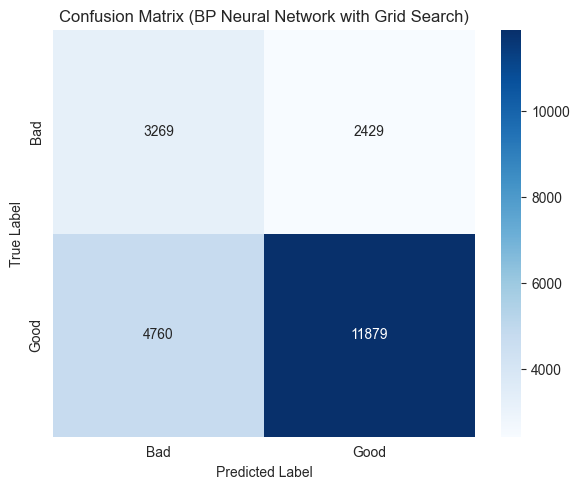

In [6]:
# Feature Selection
final_features = [
    'delivery_time', 'shipping_time', 'delivery_ratio', 'freight_ratio',
    'total_order_value', 'price_per_weight', 'description_density',
    'processing_time_approved', 'total_order_count'
]

# Separate features and labels
X_train = train_df[final_features]
y_train = train_df['review_label']

X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Apply SMOTE oversampling to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Parameter grid for MLP (BP neural network)
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (100, 50)],
#     'activation': ['relu', 'tanh'],
#     'alpha': [0.0001, 0.001],
#     'max_iter': [300]
# }
param_grid = {
    'hidden_layer_sizes': [(100,)],  # 单隐藏层，100个神经元
    'activation': ['tanh'],
    'alpha': [0.001],
    'max_iter': [300]
}

# Build GridSearchCV with MLPClassifier
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit the search
grid_search.fit(X_train_resampled, y_train_resampled)
bp_model = grid_search.best_estimator_

# Predictions
y_pred = bp_model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results

print("\n=== Classification Report ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

# Visualize the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (BP Neural Network with Grid Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# LogisticRegression

Fitting 3 folds for each of 1 candidates, totalling 3 fits
=== Best Parameters (Logistic Regression) ===
{'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

=== Classification Report (Logistic Regression) ===
Class 0:
  Precision: 0.4027
  Recall:    0.5411
  F1-score:  0.4617
  Support:   5698.0

Class 1:
  Precision: 0.8219
  Recall:    0.7252
  F1-score:  0.7705
  Support:   16639.0

Overall Accuracy: 0.6782020862246497
Macro Avg F1-score: 0.6161161980539359
Weighted Avg F1-score: 0.6917347778686725


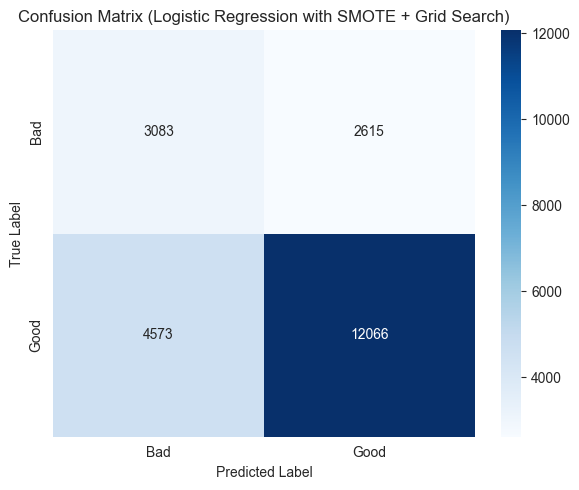

In [7]:
# Feature Preparation
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]

# Split Training and Test Sets
X_train = train_df[final_features]
y_train = train_df['review_label']
X_test = valid_df[final_features]
y_test = valid_df['review_label']

# Build Logistic Regression Training Pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Parameter Grid
# param_grid = {
#     'clf__C': [0.01, 0.1, 1, 10],
#     'clf__penalty': ['l2'],  # 'l1' can also be tried (requires solver='liblinear')
#     'clf__solver': ['lbfgs']  # 'liblinear' supports l1 and l2; lbfgs is better for l2
# }
param_grid = {
    'clf__C': [0.01],
    'clf__penalty': ['l2'],  # 'l1' can also be tried (requires solver='liblinear')
    'clf__solver': ['lbfgs']  # 'liblinear' supports l1 and l2; lbfgs is better for l2
}

# GridSearchCV Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Model Training
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_

# Model Prediction
y_pred = lr_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output Evaluation Results
print("=== Best Parameters (Logistic Regression) ===")
print(grid_search.best_params_)

print("\n=== Classification Report (Logistic Regression) ===")
for label in ['0', '1']:
    precision = report[label]['precision']
    recall = report[label]['recall']
    f1 = report[label]['f1-score']
    support = report[label]['support']
    print(f"Class {label}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-score:  {f1:.4f}")
    print(f"  Support:   {support}")
    print()

print("Overall Accuracy:", report['accuracy'])
print("Macro Avg F1-score:", report['macro avg']['f1-score'])
print("Weighted Avg F1-score:", report['weighted avg']['f1-score'])

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.title("Confusion Matrix (Logistic Regression with SMOTE + Grid Search)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Ensemble Learning — XGB + RF + LR

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best parameters: {'final_estimator__C': 0.1, 'rf__max_depth': None, 'rf__n_estimators': 200, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
=== Classification Report ===
              precision    recall  f1-score   support

           0     0.6272    0.5530    0.5878      5698
           1     0.8529    0.8874    0.8698     16639

    accuracy                         0.8021     22337
   macro avg     0.7400    0.7202    0.7288     22337
weighted avg     0.7953    0.8021    0.7979     22337


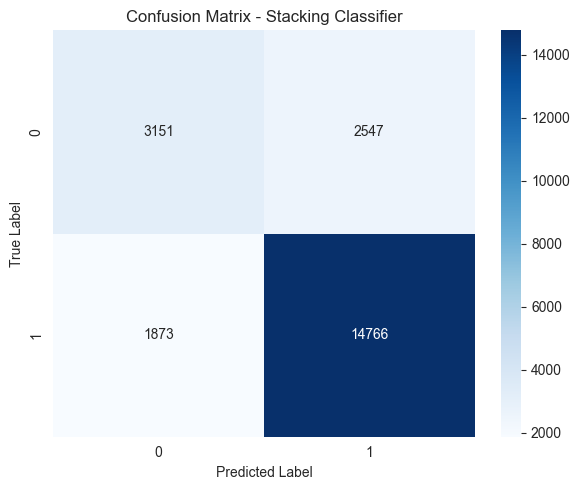

In [8]:
# Feature Preparation
final_features = [
    'delivery_time',
    'shipping_time',
    'delivery_ratio',
    'freight_ratio',
    'total_order_value',
    'price_per_weight',
    'description_density',
    'processing_time_approved',
    'total_order_count'
]

# Oversampling
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Standardization
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

from sklearn.model_selection import GridSearchCV

# Build Base Models (as above)
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

# Build Initial Stacking Model (basic, no hyperparameter tuning)
base_stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

# Hyperparameter Grid
# param_grid = {
#     'xgb__n_estimators': [50, 100],
#     'xgb__max_depth': [3, 5],
#     'rf__n_estimators': [100, 200],
#     'rf__max_depth': [None, 10],
#     'final_estimator__C': [0.1, 1.0, 10.0]
# }
param_grid = {
    'xgb__n_estimators': [50],
    'xgb__max_depth': [3],
    'rf__n_estimators':  [200],
    'rf__max_depth': [None],
    'final_estimator__C': [0.1]
}

# Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(
    estimator=base_stack,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Training with Grid Search
grid_search.fit(X_train_res_scaled, y_train_res)

# Optimal Model
stack_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)


# Prediction and Evaluation
y_pred = stack_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output Results
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Stacking Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# 模型评估


====== Logistic Regression ======
F1-Score (Class 0): 0.0180
Recall    (Class 0): 0.0091
Precision (Class 0): 0.5843
F1-Score (Class 1): 0.8539
Recall    (Class 1): 0.9978
Precision (Class 1): 0.7462
===> Macro Average (for reference only)
Avg F1-Score     : 0.4359
Avg Recall       : 0.5035
Avg Precision    : 0.6652
AUC: 0.6072
AP (Average Precision): 0.8007

====== RF ======
F1-Score (Class 0): 0.0246
Recall    (Class 0): 0.0128
Precision (Class 0): 0.3004
F1-Score (Class 1): 0.8504
Recall    (Class 1): 0.9898
Precision (Class 1): 0.7454
===> Macro Average (for reference only)
Avg F1-Score     : 0.4375
Avg Recall       : 0.5013
Avg Precision    : 0.5229
AUC: 0.4946
AP (Average Precision): 0.7381

====== XGBoost ======
F1-Score (Class 0): 0.0014
Recall    (Class 0): 0.0007
Precision (Class 0): 0.6667
F1-Score (Class 1): 0.8538
Recall    (Class 1): 0.9999
Precision (Class 1): 0.7450
===> Macro Average (for reference only)
Avg F1-Score     : 0.4276
Avg Recall       : 0.5003
Avg Precisio

D:\Python3.11.5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Python3.11.5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
D:\Python3.11.5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Python3.11.5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but BalancedRandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Python3.11.5\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
D:\Python3.11.5\Lib\site-packages\sklearn\utils\v

F1-Score (Class 0): 0.0000
Recall    (Class 0): 0.0000
Precision (Class 0): 0.0000
F1-Score (Class 1): 0.8538
Recall    (Class 1): 1.0000
Precision (Class 1): 0.7449
===> Macro Average (for reference only)
Avg F1-Score     : 0.4269
Avg Recall       : 0.5000
Avg Precision    : 0.3725
AUC: 0.5313
AP (Average Precision): 0.7382

====== Stacking ======
F1-Score (Class 0): 0.5878
Recall    (Class 0): 0.5530
Precision (Class 0): 0.6272
F1-Score (Class 1): 0.8698
Recall    (Class 1): 0.8874
Precision (Class 1): 0.8529
===> Macro Average (for reference only)
Avg F1-Score     : 0.7288
Avg Recall       : 0.7202
Avg Precision    : 0.7400
AUC: 0.7911
AP (Average Precision): 0.9010


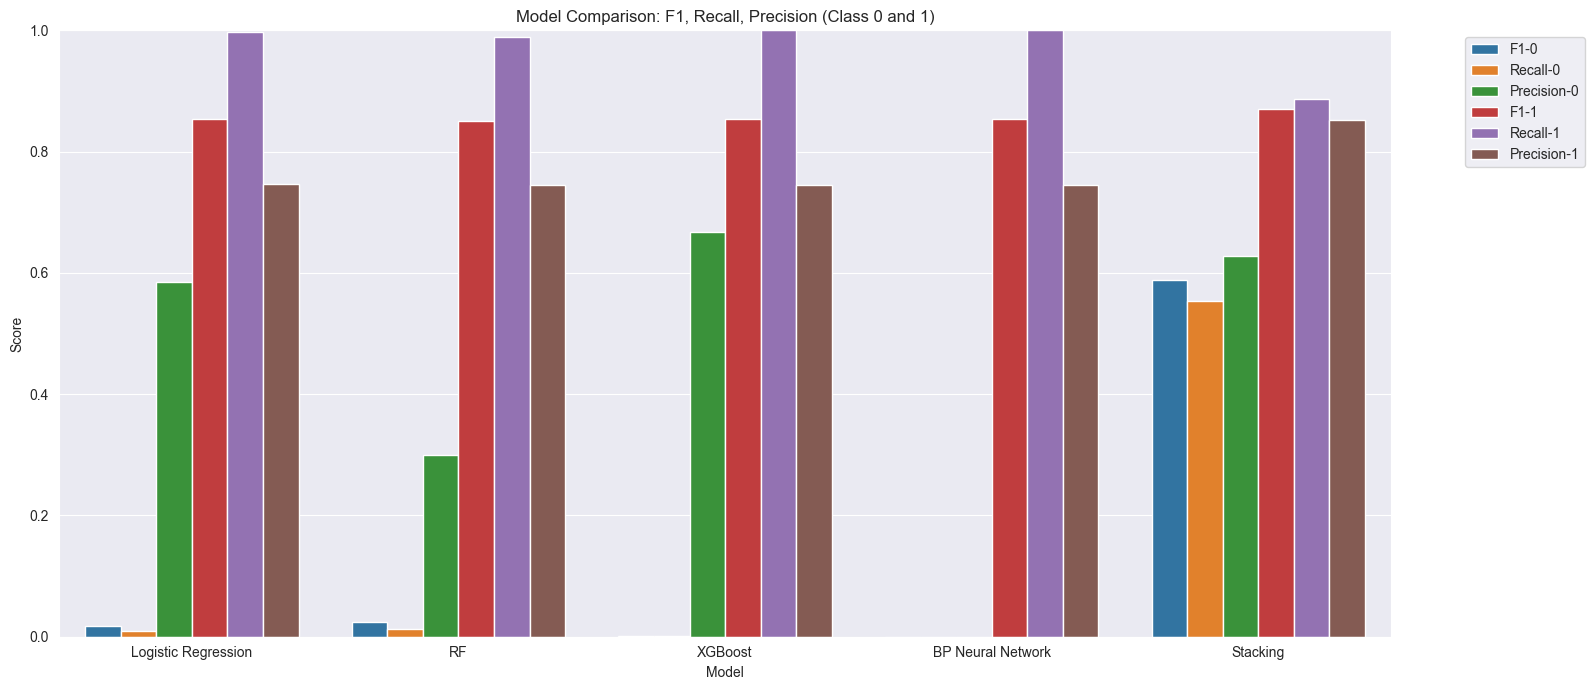

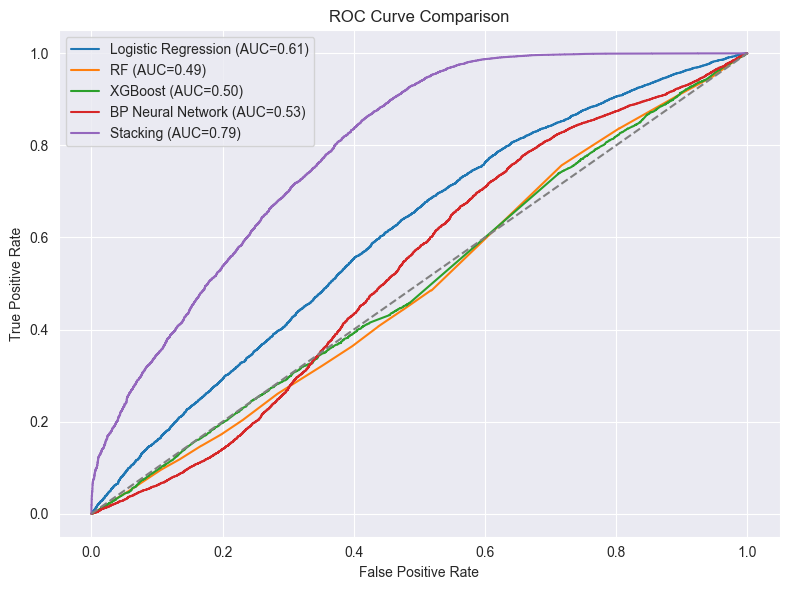

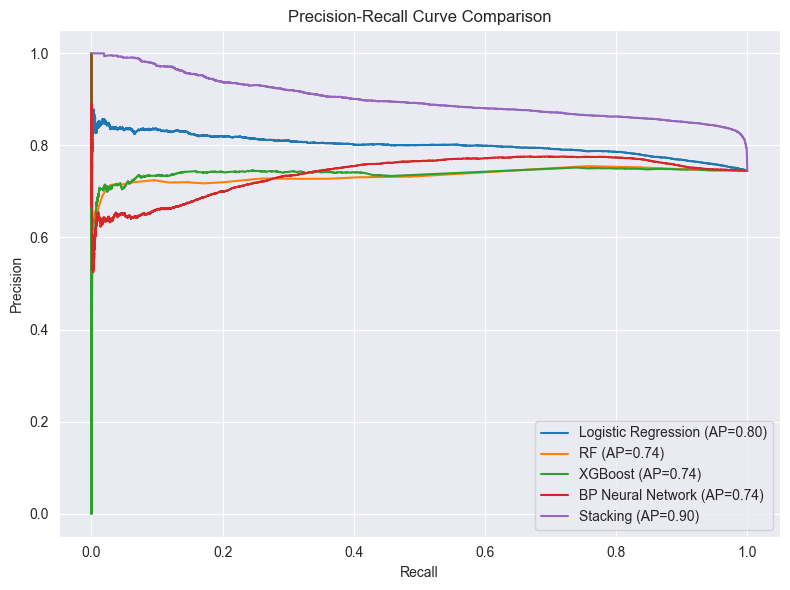

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    classification_report, roc_curve, precision_recall_curve,
    roc_auc_score, average_precision_score
)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 模型列表
models = {
    "Logistic Regression": lr_model,
    "RF": rf_model,
    "XGBoost": xgb_model,
    "BP Neural Network": bp_model,
    "Stacking": stack_model,

}

# 评估数据
X_eval = X_test_scaled  # 若未缩放，请改为 X_test
y_eval = y_test

# 存储评估结果
model_metrics = []
model_proba_curves = {}

# 模型逐个评估
for name, model in models.items():
    print(f"\n====== {name} ======")
    
    y_pred = model.predict(X_eval)

    # 处理概率预测（SVM 可能没有 predict_proba）
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_eval)[:, 1]
    else:
        decision_scores = model.decision_function(X_eval).reshape(-1, 1)
        y_proba = MinMaxScaler().fit_transform(decision_scores).ravel()

    # 计算分类指标
    report = classification_report(y_eval, y_pred, output_dict=True)
    f1_0 = report.get("0", {}).get("f1-score", 0.0)
    recall_0 = report.get("0", {}).get("recall", 0.0)
    precision_0 = report.get("0", {}).get("precision", 0.0)
    f1_1 = report.get("1", {}).get("f1-score", 0.0)
    recall_1 = report.get("1", {}).get("recall", 0.0)
    precision_1 = report.get("1", {}).get("precision", 0.0)

    # ✅ 打印但不保存 Macro 平均
    f1_avg = (f1_0 + f1_1) / 2
    recall_avg = (recall_0 + recall_1) / 2
    precision_avg = (precision_0 + precision_1) / 2

    print(f"F1-Score (Class 0): {f1_0:.4f}")
    print(f"Recall    (Class 0): {recall_0:.4f}")
    print(f"Precision (Class 0): {precision_0:.4f}")
    print(f"F1-Score (Class 1): {f1_1:.4f}")
    print(f"Recall    (Class 1): {recall_1:.4f}")
    print(f"Precision (Class 1): {precision_1:.4f}")
    print(f"===> Macro Average (for reference only)")
    print(f"Avg F1-Score     : {f1_avg:.4f}")
    print(f"Avg Recall       : {recall_avg:.4f}")
    print(f"Avg Precision    : {precision_avg:.4f}")

    # ROC 和 PR 曲线指标
    fpr, tpr, _ = roc_curve(y_eval, y_proba)
    precision, recall, _ = precision_recall_curve(y_eval, y_proba)
    auc_score = roc_auc_score(y_eval, y_proba)
    ap_score = average_precision_score(y_eval, y_proba)

    print(f"AUC: {auc_score:.4f}")
    print(f"AP (Average Precision): {ap_score:.4f}")

    # ✅ 存储仅包含 Class 0 和 1 指标
    model_metrics.append({
        "Model": name,
        "F1-0": f1_0,
        "Recall-0": recall_0,
        "Precision-0": precision_0,
        "F1-1": f1_1,
        "Recall-1": recall_1,
        "Precision-1": precision_1
    })

    model_proba_curves[name] = {
        "fpr": fpr,
        "tpr": tpr,
        "auc": auc_score,
        "precision": precision,
        "recall": recall,
        "ap": ap_score
    }

# ================= 可视化部分 =================

# 1. 分类指标柱状图（仅包含 Class 0 和 1）
metrics_df = pd.DataFrame(model_metrics)
melted_df = metrics_df.melt(
    id_vars=["Model"],
    value_name="Score",
    var_name="Metric"
)

plt.figure(figsize=(16, 7))
sns.barplot(data=melted_df, x="Model", y="Score", hue="Metric")
plt.title("Model Comparison: F1, Recall, Precision (Class 0 and 1)")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. ROC 曲线
plt.figure(figsize=(8, 6))
for name, data in model_proba_curves.items():
    plt.plot(data["fpr"], data["tpr"], label=f"{name} (AUC={data['auc']:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. PR 曲线
plt.figure(figsize=(8, 6))
for name, data in model_proba_curves.items():
    plt.plot(data["recall"], data["precision"], label=f"{name} (AP={data['ap']:.2f})")
plt.title("Precision-Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
